In [183]:
import numpy as np
import time as time
import tensorly as tl
import seaborn as sns
import matplotlib.pyplot as plt
import tensor_filter as tf

from tqdm import tqdm

sns.set()
np.set_printoptions(1)

In [190]:
def lms_filter(X,S,Step,M):
    #X: Input Vector.
    #S: Desired Signal.
    #Step: The value that'll be used to computate the error vector.
    #M: Filter Order.
    
    #Number of loops.
    I = X.size - M + 1
    #Filter output.
    Y = np.zeros((I,1))
    #Error vector.
    Error = np.zeros((I,1))
    #Matrix that will store the filter coeficients for each loop.
    W = np.zeros((M,I))
    
    for i in range(I):
        
        x = np.flipud(X[i:i + M])[:, np.newaxis]
        Y[i] = W[:,[i - 1]].T@x
        Error[i] = S[i + M - 1] - Y[i]
        
        #Updating the filter coeficients
        W[:,[i]] = W[:,[i - 1]] + Step*x*Error[i]
        Y[i] = W[:,[i]].T @ x
        
    return Y, Error, W

In [189]:
def nlms_filter(X,S,Step,M):
    #X: Input Vector.
    #S: Desired Signal.
    #Step: The value that'll be used to computate the error vector.
    #M: Filter Order.
    
    #Number of loops.
    I = X.size - M + 1
    #Filter output.
    Y = np.zeros((I,1))
    #Error vector.
    Error = np.zeros((I,1))
    #Matrix that will store the filter coeficients for each loop.
    W = np.zeros((M,I))
    
    for i in range(I):
        
        x = np.flipud(X[i:i + M])[:, np.newaxis]
        Y[i] = W[:,[i - 1]].T@x
        Error[i] = S[i + M - 1] - Y[i]
        
        #Updating the filter coeficients
        W[:,[i]] = W[:,[i - 1]] + (Step/np.linalg.norm(x))*x*Error[i]
        Y[i] = W[:,[i]].T @ x
        
    return Y, Error, W

In [331]:
def lmmse_filter(X,Y):
   
    X_approx = ((np.cov(X.T,Y.T)[0][1])/np.var(Y))*(Y - np.mean(Y)) + np.mean(X)
    NMSE = normalized_mean_square_error(X,X_approx)
    
    return X_approx, NMSE

In [279]:
def wiener_filter(received_signal,training_sequence):
    
    Rxx = received_signal@(received_signal.conj().T)/received_signal.shape[1]
    Rxs = received_signal@(training_sequence.conj())/received_signal.shape[1]
    W = (np.linalg.inv(Rxx)@Rxs)
    
    training_sequence_approx = W.T@received_signal
    nmse = normalized_mean_square_error(training_sequence,training_sequence_approx)
    
    return training_sequence_approx, nmse

In [491]:
X = np.random.randn(4,10)
Y = tf.noise(X,0)
[_,nmse] = wiener_filter(Y,X[0,:])
print(nmse)

0.23296992475558906


# LMS Test

In [218]:
transmitedsignal = tf.noise(np.random.randn(1000,),15)
h = np.convolve(transmitedsignal,np.r_[1, 2, 3, 4, 5])

[receivedsignal,Error,filter_coeficients] = lms_filter(transmitedsignal,h,0.1,10)

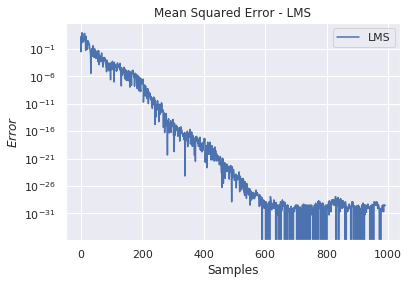

In [219]:
plt.figure()
plt.semilogy(np.abs(Error)**2, label='LMS')
plt.title('Mean Squared Error - LMS')
plt.ylabel('$Error$')
plt.xlabel('Samples')
plt.legend()
plt.savefig('NMSE x SNR - LMS.png')
plt.show()

# NLMS Test

In [230]:
transmitedsignal = tf.noise(np.random.randn(1000,),15)
h = np.convolve(transmitedsignal,np.r_[1, 2, 3, 4, 5])

[receivedsignal,Error,filter_coeficients] = nlms_filter(transmitedsignal,h,0.1,10)

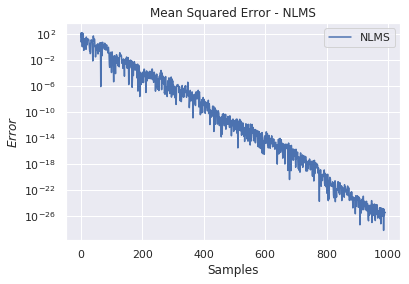

In [231]:
plt.figure()
plt.semilogy(np.abs(Error)**2, label='NLMS')
plt.title('Mean Squared Error - NLMS')
plt.ylabel('$Error$')
plt.xlabel('Samples')
plt.legend()
#plt.savefig('NMSE x SNR - NLMS.png')
plt.show()

# LMMSE Test

In [335]:
SNR_dB = -5
transmitedsignal = np.random.randn(1000,1)
receivedsignal = tf.noise(transmitedsignal,SNR_dB)
[transmitedsignal_stimation,_] = lmmse_filter(transmitedsignal,receivedsignal)

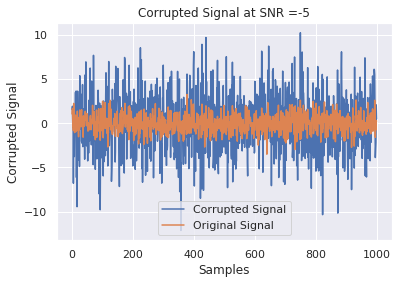

In [336]:
plt.figure()
plt.plot(receivedsignal, label='Corrupted Signal')
plt.plot(transmitedsignal, label='Original Signal')
plt.title('Corrupted Signal at SNR ='+str(SNR_dB))
plt.ylabel('Corrupted Signal')
plt.xlabel('Samples')
plt.legend()
#plt.savefig('Corrupted Signal x Original Signal - LMMSE Stimator.png')
plt.show()

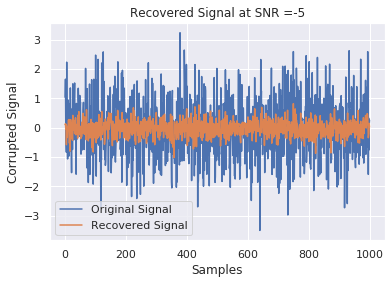

In [340]:
plt.figure()
plt.plot(transmitedsignal, label='Original Signal')
plt.plot(transmitedsignal_stimation, label='Recovered Signal')
plt.title('Recovered Signal at SNR ='+str(SNR_dB))
plt.ylabel('Corrupted Signal')
plt.xlabel('Samples')
plt.legend()
#plt.savefig('Original Signal x Filtered Signal - LMMSE Stimator.png')
plt.show()

In [343]:
NMSE = np.zeros([50,1])

for k in tqdm(range(100)):
    for i in range(0,50):
        transmitedsignal = np.random.randn(1000,1)
        receivedsignal = tf.noise(transmitedsignal,i)
        [_,nmse] = lmmse_filter(transmitedsignal,receivedsignal)
        NMSE[i,0] = NMSE[i,0] + nmse
        
NMSE = NMSE/100





  0%|          | 0/100 [00:00<?, ?it/s]



  6%|▌         | 6/100 [00:00<00:01, 58.76it/s]



 14%|█▍        | 14/100 [00:00<00:01, 62.92it/s]



 22%|██▏       | 22/100 [00:00<00:01, 67.01it/s]



 31%|███       | 31/100 [00:00<00:00, 70.68it/s]



 39%|███▉      | 39/100 [00:00<00:00, 72.43it/s]



 46%|████▌     | 46/100 [00:00<00:00, 70.65it/s]



 53%|█████▎    | 53/100 [00:00<00:00, 69.16it/s]



 61%|██████    | 61/100 [00:00<00:00, 71.53it/s]



 70%|███████   | 70/100 [00:00<00:00, 74.30it/s]



 79%|███████▉  | 79/100 [00:01<00:00, 76.45it/s]



 88%|████████▊ | 88/100 [00:01<00:00, 77.89it/s]



100%|██████████| 100/100 [00:01<00:00, 75.60it/s][A


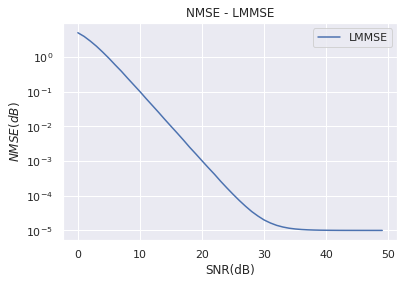

In [344]:
plt.figure()
plt.semilogy(10*NMSE, label='LMMSE')
plt.title('NMSE - LMMSE')
plt.ylabel('$NMSE(dB)$')
plt.xlabel('SNR(dB)')
plt.legend()
plt.savefig('NMSE X SNR - LMMSE Stimator.png')
plt.show()

# Wiener Test with a Full Channel  Model

In [126]:
NMSE = np.zeros([50,1])
N,Q,L,U,K = 512,16,4,2,4096

runs = 100
for k in tqdm(range(runs)):
    for i in range(0,50):
        h = tf.channel(N,Q,L,U)
        sm = tf.modulated_signal(K,U)
        S = tf.sampled_matrix(sm,K,Q,U)
        [receivedsignal,transmitedsignal] = tf.received_signal(S,h,i)
        training_sequence = (sm[:,0])[:,None]
        [training_sequence_approx,nmse] = wiener_filter(receivedsignal,training_sequence)
        NMSE[i] = NMSE[i] + nmse
        
NMSE = NMSE/runs


100%|██████████| 100/100 [46:34<00:00, 27.94s/it]


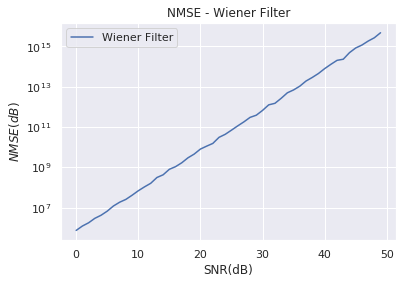

In [128]:
plt.figure()
plt.semilogy(10*NMSE, label='Wiener Filter')
plt.title('NMSE - Wiener Filter')
plt.ylabel('$NMSE(dB)$')
plt.xlabel('SNR(dB)')
plt.legend()
plt.savefig('NMSE X SNR - Wiener Filter.png')
plt.show()